In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

from spicy_snow.retrieval import retrieval_from_parameters

In [3]:
lievens_params = [2, 0.5, 0.44]
# wus_params = [2.5, 0.2, 0.55]
# wus_v2_params = [1.5, 0.1, 0.59]

in_dir = Path('~/spicy-snow/SnowEx-Data/').expanduser().resolve()
data_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()

# Create parameter space
A = np.round(np.arange(1, 3.1, 0.1), 2)
B = np.round(np.arange(0, 2.01, 0.1), 2)
C = np.round(np.arange(0, 1.001, 0.01), 2)

def bias(x, y): return np.mean(x - y)

def get_stats(x, y):
    if type(x) == xr.DataArray: x = x.values.ravel()
    if type(y) == xr.DataArray: y = y.values.ravel()
    idx = (~np.isnan(x)) & (~np.isnan(y))
    x, y = x[idx], y[idx]
    r, p = pearsonr(x, y)
    b = bias(x, y)
    mae = mean_absolute_error(x, y)
    rmse = mean_squared_error(x, y, squared = False)
    return r, b, mae, rmse

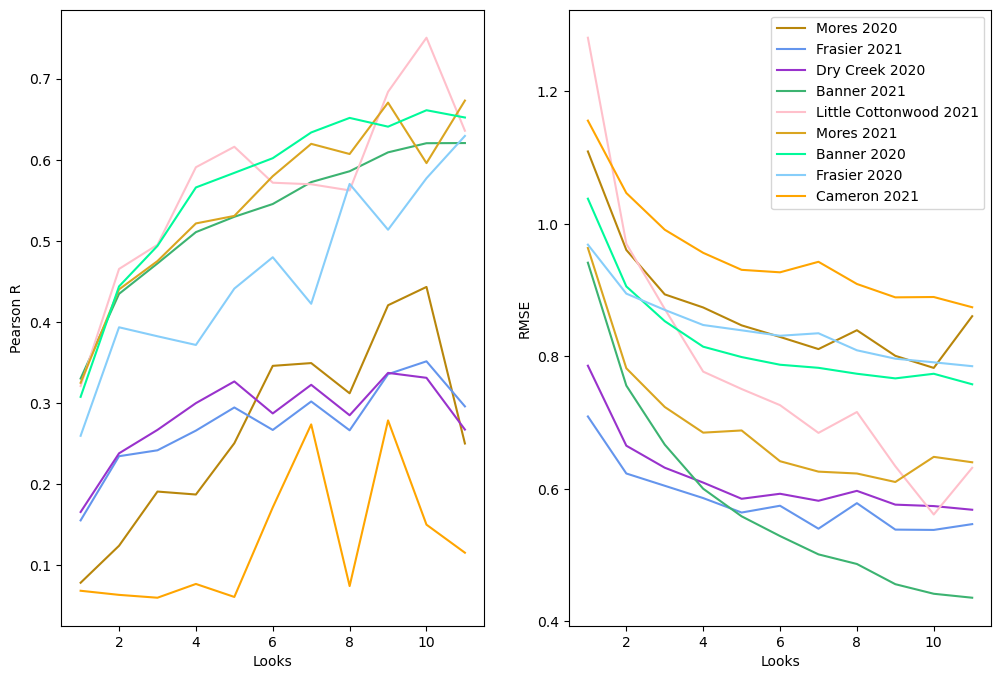

In [23]:
fig, axes = plt.subplots(1, 2, figsize = (12, 8))

loc_colors = {'Banner_2020-02-18': 'mediumspringgreen', 'Banner_2021-03-15': 'mediumseagreen', 'Cameron_2021-03-19': 'orange', \
    'Dry_Creek_2020-02-19': 'darkorchid', 'Frasier_2020-02-11': 'lightskyblue', 'Frasier_2021-03-19': 'cornflowerblue', \
        'Little_Cottonwood_2021-03-18': 'pink', 'Mores_2020-02-09': 'darkgoldenrod', 'Mores_2021-03-15': 'goldenrod'}

for fp in in_dir.glob('*.nc'):
    ds = xr.open_dataset(fp)

    if fp.stem == 'Frasier_2020-02-11':
        im_date = pd.to_datetime('2020-02-16')
    else:
        im_date = pd.to_datetime(ds.sel(time = ds.attrs['lidar-flight-time'], method = 'nearest').time.values.ravel()[0])

    site_name = fp.stem.replace('_', ' ').split('-')[0]

    xs = []
    rs = []
    rmses = []
    for look in range(1, 12):
        ds_500 = ds.coarsen(x = look, y = look, boundary = 'pad').mean()
        r, b, mae, rmse  = get_stats(ds_500['lidar-sd'], ds_500['snow_depth'].sel(time = im_date, method = 'nearest'))

        xs.append(look)
        rs.append(r)
        rmses.append(rmse)
        
    axes[0].plot(xs, rs, color = loc_colors[fp.stem])
    axes[1].plot(xs, rmses, color = loc_colors[fp.stem], label = site_name)

    # xs = []
    # rs = []
    # rmses = []
    # for look in range(1, 12):
    #     ds_500 = ds.coarsen(x = look, y = look, boundary = 'pad').mean()
    #     idx = ds_500['wet_snow'].sel(time = im_date, method = 'nearest') < 0.5
    #     if sum(idx.values.ravel()) < 10:
    #         continue
    #     r, b, mae, rmse  = get_stats(ds_500['lidar-sd'].where(idx), ds_500['snow_depth'].sel(time = im_date, method = 'nearest').where(idx))
    #     xs.append(look)
    #     rs.append(r)
    #     rmses.append(rmse)
    
    # axes[0].plot(xs, rs, color = loc_colors[fp.stem], linestyle = 'dashed')
    # axes[1].plot(xs, rmses, color = loc_colors[fp.stem], linestyle = 'dashed')

for ax in axes:
    ax.set_xlabel('Looks')
axes[0].set_ylabel('Pearson R')
axes[1].set_ylabel('RMSE')
axes[1].legend()

In [25]:
npy_dirs = Path('/bsuhome/zacharykeskinen/scratch/spicy/param_npys')
all_res = xr.open_dataset(npy_dirs.joinpath('grouped.nc'))
print(all_res['pearsonr'].max(['B', 'C']).idxmax('A'))
print(all_res['pearsonr'].max(['C', 'A']).idxmax('B'))
print(all_res['mae'].min(['A', 'B']).idxmin('C'))

<xarray.DataArray 'A' ()>
array(1.5)
<xarray.DataArray 'B' ()>
array(0.)
<xarray.DataArray 'C' ()>
array(0.27)


In [26]:
# for fp in in_dir.glob('*.nc'):
#     ds = xr.open_dataset(fp)

#     if fp.stem == 'Frasier_2020-02-11':
#         r, b, mae, rmse = get_stats(ds['lidar-sd'], ds['snow_depth'].sel(time = '2020-02-16'))
#         im_date = pd.to_datetime(ds.sel(time = '2020-02-16', method = 'nearest').time.values.ravel()[0])
#     else:
#         r, b, mae, rmse = get_stats(ds['lidar-sd'], ds['snow_depth'].sel(time = ds.attrs['lidar-flight-time'], method = 'nearest'))
#         im_date = pd.to_datetime(ds.sel(time = ds.attrs['lidar-flight-time'], method = 'nearest').time.values.ravel()[0])
#     d_days = im_date - pd.to_datetime(ds.attrs['lidar-flight-time'])
#     print(fp.stem)
#     print(d_days)

In [29]:
res = pd.DataFrame()
coarse_x = []
coarse_y = []

coarse_x_1k = []
coarse_y_1k = []
for fp in in_dir.glob('*.nc'):
    ds = xr.open_dataset(fp)

    if fp.stem == 'Frasier_2020-02-11':
        r, b, mae, rmse = get_stats(ds['lidar-sd'], ds['snow_depth'].sel(time = '2020-02-16'))
        im_date = pd.to_datetime('2020-02-16')
    else:
        r, b, mae, rmse = get_stats(ds['lidar-sd'], ds['snow_depth'].sel(time = ds.attrs['lidar-flight-time'], method = 'nearest'))
        im_date = pd.to_datetime(ds.sel(time = ds.attrs['lidar-flight-time'], method = 'nearest').time.values.ravel()[0])
    d_days = im_date - pd.to_datetime(ds.attrs['lidar-flight-time'])

    site_name = fp.stem.replace('_', ' ').split('-')[0]

    # add RMSE and bias @ 90m
    for name, var in zip(['RMSE', 'Pearson R'], [rmse, r]):
        res.loc[site_name, name] = var

    # for dry only
    idx = ds['wet_snow'].sel(time = im_date, method = 'nearest') == 0
    r, b, mae, rmse  = get_stats(ds['lidar-sd'].where(idx), ds['snow_depth'].sel(time = im_date, method = 'nearest').where(idx))
    for name, var in zip(['RMSE'], [rmse]):
        res.loc[site_name, name + ' (Dry)'] = var

    # @ 300 m
    ds_500 = ds.coarsen(x = 3, y = 3, boundary = 'pad').mean()
    r, b, mae, rmse  = get_stats(ds_500['lidar-sd'], ds_500['snow_depth'].sel(time = im_date, method = 'nearest'))
    coarse_x.append(ds_500['lidar-sd'].values.ravel())
    coarse_y.append(ds_500['snow_depth'].sel(time = im_date, method = 'nearest').values.ravel())

    for name, var in zip(['RMSE', 'Pearson R'], [rmse, r]):
        res.loc[site_name, name+' @ 300m'] = var

    # @ 500 m
    ds_500 = ds.coarsen(x = 6, y = 6, boundary = 'pad').mean()
    r, b, mae, rmse  = get_stats(ds_500['lidar-sd'], ds_500['snow_depth'].sel(time = im_date, method = 'nearest'))
    coarse_x.append(ds_500['lidar-sd'].values.ravel())
    coarse_y.append(ds_500['snow_depth'].sel(time = im_date, method = 'nearest').values.ravel())

    for name, var in zip(['RMSE', 'Pearson R'], [rmse, r]):
        res.loc[site_name, name+' @ 500m'] = var

    # @ 1 km

    ds_500 = ds.coarsen(x = 11, y = 11, boundary = 'pad').mean()
    r, b, mae, rmse  = get_stats(ds_500['lidar-sd'], ds_500['snow_depth'].sel(time = im_date, method = 'nearest'))
    coarse_x_1k.append(ds_500['lidar-sd'].values.ravel())
    coarse_y_1k.append(ds_500['snow_depth'].sel(time = im_date, method = 'nearest').values.ravel())

    for name, var in zip(['RMSE', 'Pearson R'], [rmse, r]):
        res.loc[site_name, name+' @ 1km'] = var


for name, var in zip(['RMSE', 'Pearson R'], [rmse, r]):
    res.loc['All Sites', name] = all_res.sel(A = 1.5, B = 0.1, C = 0.59)[name.lower().replace(' ', '')]

r, b, mae, rmse  = get_stats(np.concatenate(coarse_x).ravel(), np.concatenate(coarse_y).ravel())
for name, var in zip(['RMSE', 'Pearson R'], [rmse, r]):
    res.loc['All Sites', name+' @ 500m'] = var

r, b, mae, rmse  = get_stats(np.concatenate(coarse_x_1k).ravel(), np.concatenate(coarse_y_1k).ravel())
for name, var in zip(['RMSE', 'Pearson R'], [rmse, r]):
    res.loc['All Sites', name+' @ 1km'] = var

In [30]:
cols = res.index
cols = cols.drop('All Sites')
cols = cols.insert(0, 'All Sites')
res= res.reindex(cols)

res = res.applymap(lambda x : f'{x:.2f}')
res

,RMSE,Pearson R,RMSE (Dry),RMSE @ 300m,Pearson R @ 300m,RMSE @ 500m,Pearson R @ 500m,RMSE @ 1km,Pearson R @ 1km
All Sites,0.98,0.38,nan,nan,nan,0.75,0.53,0.65,0.64
Mores 2020,1.11,0.08,0.94,0.89,0.19,0.83,0.35,0.86,0.25
Frasier 2021,0.71,0.16,0.73,0.60,0.24,0.57,0.27,0.55,0.30
Dry Creek 2020,0.79,0.17,0.78,0.63,0.27,0.59,0.29,0.57,0.27
Banner 2021,0.94,0.33,0.95,0.67,0.47,0.53,0.55,0.44,0.62
Little Cottonwood 2021,1.28,0.32,1.30,0.87,0.50,0.73,0.57,0.63,0.64
Mores 2021,0.96,0.33,0.87,0.72,0.48,0.64,0.58,0.64,0.67
Banner 2020,1.04,0.31,0.92,0.85,0.49,0.79,0.60,0.76,0.65
Frasier 2020,0.97,0.26,1.06,0.87,0.38,0.83,0.48,0.79,0.63
Cameron 2021,1.16,0.07,1.04,0.99,0.06,0.93,0.17,0.87,0.12


In [7]:
# res.to_csv('/bsuhome/zacharykeskinen/spicy-analysis/results/table1.csv')

In [8]:
# res = pd.DataFrame()
# coarse_x = []
# coarse_y = []

# coarse_x_1k = []
# coarse_y_1k = []
# for fp in in_dir.glob('*.nc'):
#     ds = xr.open_dataset(fp)

#     if fp.stem == 'Frasier_2020-02-11':
#         r, b, mae, rmse = get_stats(ds['lidar-sd'], ds['snow_depth'].sel(time = '2020-02-16'))
#         im_date = pd.to_datetime('2020-02-16')
#     else:
#         r, b, mae, rmse = get_stats(ds['lidar-sd'], ds['snow_depth'].sel(time = ds.attrs['lidar-flight-time'], method = 'nearest'))
#         im_date = pd.to_datetime(ds.sel(time = ds.attrs['lidar-flight-time'], method = 'nearest').time.values.ravel()[0])
#     d_days = im_date - pd.to_datetime(ds.attrs['lidar-flight-time'])

#     site_name = fp.stem.replace('_', ' ').split('-')[0]
#     for name, var in zip(['RMSE', 'Pearson R'], [rmse, r]):
#         res.loc[site_name, name] = var

#     ds_500 = ds.coarsen(x = 6, y = 6, boundary = 'pad').mean()
#     r, b, mae, rmse  = get_stats(ds_500['lidar-sd'], ds_500['snow_depth'].sel(time = im_date, method = 'nearest'))
#     coarse_x.append(ds_500['lidar-sd'].values.ravel())
#     coarse_y.append(ds_500['snow_depth'].sel(time = im_date, method = 'nearest').values.ravel())

#     for name, var in zip(['RMSE', 'Pearson R'], [rmse, r]):
#         res.loc[site_name, name+' @ 500m'] = var

#     ds_500 = ds.coarsen(x = 11, y = 11, boundary = 'pad').mean()
#     r, b, mae, rmse  = get_stats(ds_500['lidar-sd'], ds_500['snow_depth'].sel(time = im_date, method = 'nearest'))
#     coarse_x_1k.append(ds_500['lidar-sd'].values.ravel())
#     coarse_y_1k.append(ds_500['snow_depth'].sel(time = im_date, method = 'nearest').values.ravel())

#     for name, var in zip(['RMSE', 'Pearson R'], [rmse, r]):
#         res.loc[site_name, name+' @ 1km'] = var

#     # lievens_ds = retrieval_from_parameters(xr.open_dataset(data_dir.joinpath(fp.name)), A = lievens_params[0], B = lievens_params[1], C = lievens_params[2])

#     # o_r, o_b, o_mae, o_rmse = get_stats(lievens_ds['lidar-sd'], lievens_ds['snow_depth'].sel(time = im_date, method = 'nearest'))

#     # res.loc[site_name, 'Lievens (2022) rmse'] = o_rmse
#     # res.loc[site_name, 'Lievens (2022) Pearson R'] = o_r

# for name, var in zip(['RMSE', 'Pearson R'], [rmse, r]):
#     res.loc['All Sites', name] = all_res.sel(A = 1.5, B = 0.1, C = 0.59)[name.lower().replace(' ', '')]
# # res.loc['All Sites', 'Lievens (2022) rmse'] = all_res.sel(A = lievens_params[0], B = lievens_params[1], C = lievens_params[2])['rmse']
# # res.loc['All Sites', 'Lievens (2022) Pearson R'] = all_res.sel(A = lievens_params[0], B = lievens_params[1], C = lievens_params[2])['pearsonr']

# r, b, mae, rmse  = get_stats(np.concatenate(coarse_x).ravel(), np.concatenate(coarse_y).ravel())
# for name, var in zip(['RMSE', 'Pearson R'], [rmse, r]):
#     res.loc['All Sites', name+' @ 500m'] = var

# r, b, mae, rmse  = get_stats(np.concatenate(coarse_x_1k).ravel(), np.concatenate(coarse_y_1k).ravel())
# for name, var in zip(['RMSE', 'Pearson R'], [rmse, r]):
#     res.loc['All Sites', name+' @ 1km'] = var